# Przewidywanie wystąpienia udaru

In [35]:
import pandas as pd
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix
from sklearn.metrics import ConfusionMatrixDisplay
import random
from joblib import dump, load
import numpy as np


In [30]:
df = pd.read_csv("../data/heart_2020.csv")
df

,HeartDisease,BMI,Smoking,AlcoholDrinking,Stroke,PhysicalHealth,MentalHealth,DiffWalking,Sex,AgeCategory,Race,Diabetic,PhysicalActivity,GenHealth,SleepTime,Asthma,KidneyDisease,SkinCancer
0,No,20.80,Yes,Yes,No,0.0,3.0,No,Female,45-49,Hispanic,No,Yes,Very good,8.0,No,No,No
1,No,28.15,No,No,No,0.0,0.0,No,Female,65-69,White,No,Yes,Very good,7.0,No,No,Yes
2,No,25.25,No,No,No,0.0,30.0,Yes,Female,75-79,White,No,No,Fair,6.0,No,No,No
3,No,25.10,No,No,No,0.0,0.0,No,Male,60-64,White,No,Yes,Excellent,5.0,No,No,No
4,No,33.38,No,Yes,No,0.0,2.0,No,Male,65-69,White,No,Yes,Good,8.0,No,No,Yes
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
319790,No,25.42,Yes,No,No,0.0,5.0,No,Female,70-74,White,No,Yes,Very good,8.0,No,No,No
319791,No,32.98,Yes,No,No,0.0,0.0,Yes,Male,40-44,Other,No,Yes,Fair,8.0,Yes,No,No
319792,No,27.44,No,No,No,30.0,0.0,Yes,Female,55-59,White,No,No,Very good,6.0,No,No,No
319793,No,24.21,Yes,No,No,0.0,30.0,Yes,Male,50-54,Black,No,Yes,Good,5.0,No,No,No


In [3]:
df.columns

Index(['HeartDisease', 'BMI', 'Smoking', 'AlcoholDrinking', 'Stroke',
       'PhysicalHealth', 'MentalHealth', 'DiffWalking', 'Sex', 'AgeCategory',
       'Race', 'Diabetic', 'PhysicalActivity', 'GenHealth', 'SleepTime',
       'Asthma', 'KidneyDisease', 'SkinCancer'],
      dtype='object')

In [4]:
with open("diab.txt", "w") as f:
    f.writelines('\n'.join(list(df['Diabetic'])))

### Mapowanie kategorii na liczby (im większa liczba tym ważniejsza dla modelu jest wartość)
np. słabe generalne zdrowie wpływa na wystąpienie udaru, więc ma wartość 4

In [5]:
age_map = {}
l = list(set(df['AgeCategory']))
l.sort()
for i, v in enumerate(l):
    age_map[v] = i

print(age_map)

{'18-24': 0, '25-29': 1, '30-34': 2, '35-39': 3, '40-44': 4, '45-49': 5, '50-54': 6, '55-59': 7, '60-64': 8, '65-69': 9, '70-74': 10, '75-79': 11, '80 or older': 12}


In [6]:
health_map = {
    'Excellent': 0,
    'Very good': 1,
    'Good': 2, 
    'Fair': 3, 
    'Poor': 4
}

In [7]:
bool_map = {
    "Yes": 1,
    "No": 0
}

In [8]:
race_map = {
    'White': 0,
    'Black': 1,
    'Asian': 2,
    'Other': 3,
    'American Indian/Alaskan Native': 4,
    'Hispanic': 5
}


In [9]:
sex_map = {
    "Male": 1,
    "Female": 0
}

In [10]:
diabetic_map = {
    'No': 0,
    'Yes': 1,
    'No, borderline diabetes': 2,
    'Yes (during pregnancy)': 3
}

In [11]:
Y = df.pop("Stroke").map({'Yes':1, 'No':0})
X = df

In [12]:
X['AgeCategory'] = X['AgeCategory'].map(age_map)
X['GenHealth'] = X['GenHealth'].map(health_map)
X['Race'] = X['Race'].map(race_map)
X['Sex'] = X['Sex'].map(sex_map)
X['Diabetic'] = X['Diabetic'].map(diabetic_map)

### Faktoryzacja danych (zamiana stringów na liczby)
w tym przypadku bez brania pod uwagę znaczenia cechy

In [13]:
for i in X:
    if X[i].dtype == object:
        X[i] = X[i].map(bool_map)

In [14]:
X.head()

,HeartDisease,BMI,Smoking,AlcoholDrinking,PhysicalHealth,MentalHealth,DiffWalking,Sex,AgeCategory,Race,Diabetic,PhysicalActivity,GenHealth,SleepTime,Asthma,KidneyDisease,SkinCancer
0,0,20.80,1,1,0.0,3.0,0,0,5,5,0,1,1,8.0,0,0,0
1,0,28.15,0,0,0.0,0.0,0,0,9,0,0,1,1,7.0,0,0,1
2,0,25.25,0,0,0.0,30.0,1,0,11,0,0,0,3,6.0,0,0,0
3,0,25.10,0,0,0.0,0.0,0,1,8,0,0,1,0,5.0,0,0,0
4,0,33.38,0,1,0.0,2.0,0,1,9,0,0,1,2,8.0,0,0,1


In [15]:
set(X['Diabetic'])

{0, 1, 2, 3}

### Podział zbioru na zbiór testowy i treningowy

In [16]:
x_train, x_test, y_train, y_test = train_test_split(X, Y, test_size=0.20)

### Wyrzucenie ze zbioru treningowego zer (braków wystąpienia udaru)
rozkład wystąpienia udaru do niewystąpienia udaru to 50/50

In [17]:
x1_train = x_train[y_train == 1]
x0_train = x_train[y_train == 0]

In [18]:
y1_train = y_train[y_train == 1]
y0_train = y_train[y_train == 0]

### Wylosowanie zer do zbioru treningowego

In [19]:
indexes = random.sample(range(len(y0_train)), k=len(y1_train))

In [20]:
x0_train = x0_train.iloc[indexes]
y0_train = y0_train.iloc[indexes]

### Połączenie zbiorów z zerami i jedynkami

In [21]:
x_train = pd.concat([x0_train, x1_train], axis=0)
y_train = pd.concat([y0_train, y1_train], axis=0)

In [22]:
print(f"x_train shape: {x_train.shape}")
print(f"y_train shape: {y_train.shape}")
print(f"x_test shape:  {x_test.shape}")
print(f"y_test shape:  {y_test.shape}")

x_train shape: (19346, 17)
y_train shape: (19346,)
x_test shape:  (63959, 17)
y_test shape:  (63959,)


### Trening modelu i wyliczenie wyniku

In [23]:
model = GradientBoostingClassifier()
model.fit(x_train, y_train)
score = model.score(x_test, y_test)

In [24]:
print(f"score: {score:.2f}")

score: 0.72


In [25]:
y_pred = model.predict_proba(x_test)[:,1]

In [26]:
y_true = y_test

### Wyniki

In [27]:
cm = confusion_matrix(y_true, y_pred>0.4, normalize='true')

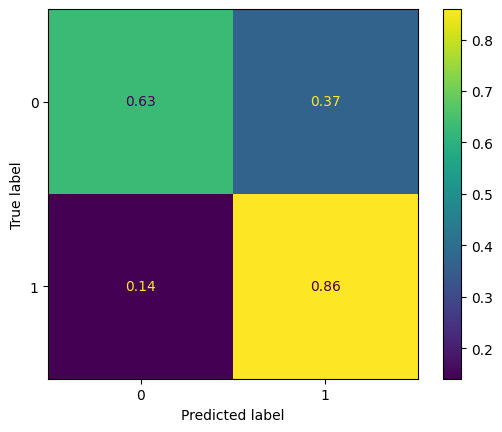

In [28]:
ConfusionMatrixDisplay(cm).plot()

Powyższa grafika przedstawia zależność prawdziwych wartości od przewidzianych wartości. Od lewego górnego kwadratu przedstawia:
1. ilość poprawnie przewidzianych braków udaru podzieloną przez ilość wszystkich braków wystąpienia udarów
2. ilość przewidzianych udarów, które faktycznie nie wystąpiły podzieloną przez ilość wszystkich braków wystąpienia udarów
3. ilość przewidzianych braków udaru, które faktycznie wystąpiły podzieloną przez ilość wszystkich udarów, które wystąpiły
4. ilość przewidzianch udarów, które faktycznie wystąpiły podzieloną przez ilość wszystkich udarów, które wystąpiły

Ilość fałszywie wykrytych udarów jest dość wysoka, ale w tym przypadku lepiej jest fałszywie wykryć udar niż fałszywie wykryć brak udaru, ponieważ w ten sposób ograniczamy ilość zgonów 

In [29]:
dump(model, 'model.joblib')

['model.joblib']